In [1]:
import easyocr
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
reader = easyocr.Reader(['en'], gpu=True) # this needs to run only once to load the model into memory
image_name = 'images/test_image.png'

### Origin Image

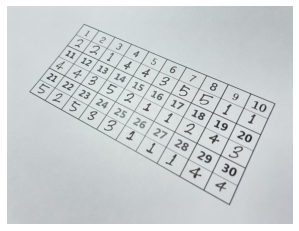

In [3]:
img = cv2.imread(image_name, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(img)
plt.show()

### GrayScale

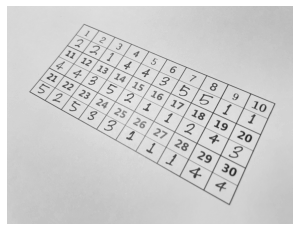

In [4]:
img_gray = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
plt.axis('off')
plt.imshow(img_gray, cmap='gray')
plt.show()

### Blur

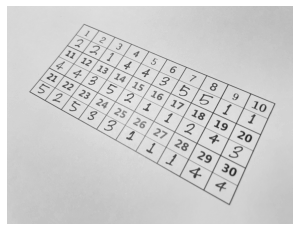

In [5]:
blur = cv2.GaussianBlur(img_gray, ksize=(9, 9), sigmaX=0)
plt.axis('off')
plt.imshow(img_gray, cmap='gray')
plt.show()

### Adaptive Threshold

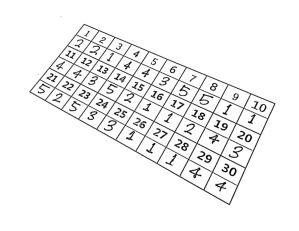

In [6]:
adaptive_thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 3)
cv2.imwrite('/work/users/ckim/dev/mp_ocr/images_write/test_adaptive_thresh.jpg', adaptive_thresh)

plt.axis('off')
plt.imshow(adaptive_thresh, cmap='gray')
plt.show()

### Threshold

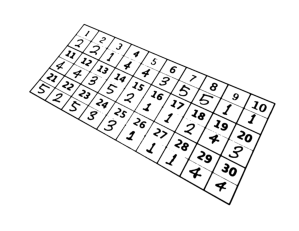

In [7]:
ret, thresh = cv2.threshold(blur, 170, 255, cv2.THRESH_BINARY)
cv2.imwrite('/work/users/ckim/dev/mp_ocr/images_write/test_threshold.jpg', thresh)

plt.axis('off')
plt.imshow(thresh, cmap='gray')
plt.show()

### Contour

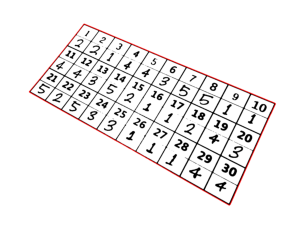

In [8]:
img_copy = np.copy(thresh)
img_copy = cv2.cvtColor(img_copy, cv2.COLOR_GRAY2RGB)

binary = cv2.bitwise_not(thresh)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# 잡음 버리기
max_contours = []
for c in contours:
    if len(max_contours) < len(c):
        max_contours = c

# 외곽선만 추출
for contour in max_contours:
    cv2.drawContours(img_copy, [contour], 0, (255, 0, 0), 3)

plt.axis('off')
plt.imshow(img_copy, cmap='gray')
plt.show()

### Approach Contour

[[430 102]]
[[125 482]]
[[1250 1116]]
[[1506  546]]
(125, 1) (1506, 3)


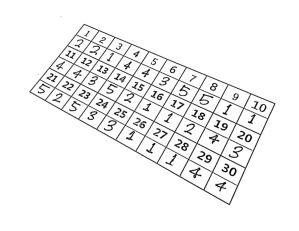

In [9]:
epsilon = 0.05 * cv2.arcLength(max_contours, True)
approx = list(cv2.approxPolyDP(max_contours, epsilon, True))
min_axis = (1e9, 0)
max_axis = (-1e9, 0)

# 꼭지점 검출
for idx, app in enumerate(approx):
    cv2.circle(thresh, (app[0]), 3, (0, 255, 0), 5)
    print(app)

    # x좌표 최소값, 최대값 구하기
    min_axis = (app[0][0], idx) if app[0][0] < min_axis[0] else min_axis
    max_axis = (app[0][0], idx) if app[0][0] > max_axis[0] else max_axis
print(min_axis, max_axis)
plt.axis('off')
plt.imshow(adaptive_thresh, cmap='gray')
plt.show()

### Projection

#### Sort

In [10]:
warp_approx = approx.copy()
if min_axis[1] == 0:
    pass
else:
    for i in range(min_axis[1]):
        warp_approx.append(warp_approx.pop(0))
print(warp_approx)


[array([[125, 482]], dtype=int32), array([[1250, 1116]], dtype=int32), array([[1506,  546]], dtype=int32), array([[430, 102]], dtype=int32)]


In [11]:
alu, aru, ard, ald = (), (), (), ()

if warp_approx[1][0][0] > warp_approx[3][0][0]:
    alu, aru, ard, ald = warp_approx[3][0], warp_approx[2][0], warp_approx[1][0], warp_approx[0][0]
elif warp_approx[1][0][0] < warp_approx[3][0][0]:
    alu, aru, ard, ald = warp_approx[0][0], warp_approx[3][0], warp_approx[2][0], warp_approx[1][0]

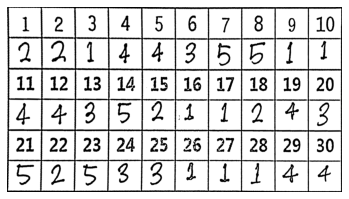

In [12]:
nx, ny = img.shape[1]+(img.shape[0]//2), img.shape[0]

pts1 = np.float32([alu, aru, ard, ald])
pts2 = np.float32([(0, 0), (nx, 0), (nx, ny), (0, ny)])

perspect_mat = cv2.getPerspectiveTransform(pts1, pts2)
dst = cv2.warpPerspective(adaptive_thresh, perspect_mat, (nx, ny), cv2.INTER_LANCZOS4)
cv2.imwrite('/work/users/ckim/dev/mp_ocr/images_write/test_dst.jpg', dst)

plt.axis('off')
plt.imshow(dst, cmap='gray')
plt.show()

### Image Detection

920.8651368309256
1162
77.2879532910169
281
[([[90, 72], [162, 72], [162, 172], [90, 172]], '1', 0.9979992393730299), ([[299, 53], [387, 53], [387, 185], [299, 185]], '2', 1.0), ([[522, 44], [598, 44], [598, 172], [522, 172]], '3', 0.9944517558838641), ([[745, 53], [831, 53], [831, 169], [745, 169]], '4', 0.9790806838048891), ([[968, 52], [1042, 52], [1042, 174], [968, 174]], '5', 1.0), ([[1188, 54], [1266, 54], [1266, 172], [1188, 172]], '6', 0.9999949932161059), ([[1415, 77], [1475, 77], [1475, 169], [1415, 169]], '7', 0.9960819788421169), ([[1626, 54], [1706, 54], [1706, 174], [1626, 174]], '8', 1.0), ([[1848, 64], [1920, 64], [1920, 174], [1848, 174]], '9', 0.9999967813517721), ([[2027, 43], [2185, 43], [2185, 184], [2027, 184]], '10', 0.9999989884757856), ([[77.2879532910169, 230.02821146681296], [151.37898588609144, 239.7842872259749], [132.7120467089831, 373.971788533187], [58.62101411390856, 364.2157127740251]], '2', 0.9868415024810453), ([[281, 199], [391, 199], [391, 365], [2

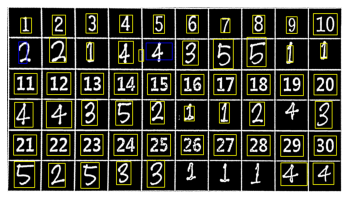

In [14]:
image = cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB)
image_not = cv2.bitwise_not(image)
result = reader.readtext(image_not, text_threshold=0.05, link_threshold=0.9, low_text= 0.32, min_size=50, blocklist="|", allowlist="0123456789", output_format='free_merge')
image_not_result = image_not.copy()
flag = False

idx_images = 0
for r in result:
    flag = False

    rx1, ry1 = int(r[0][0][0]), int(r[0][0][1])
    rx2, ry2 = int(r[0][2][0]), int(r[0][2][1])

    if "int" not in str(type(r[0][0][0])):
        image_not_result = cv2.rectangle(image_not, (rx1, ry1), (rx2, ry2), (0, 0, 255), 3)
    elif len(r[1]) > 2:
        image_not_result = cv2.rectangle(image_not, (rx1, ry1), (rx2, ry2), (0, 255, 0), 3)
    else:
        image_not_result = cv2.rectangle(image_not, (rx1, ry1), (rx2, ry2), (255, 255, 0), 3)
    
    # cv2.imwrite(f'save_images/{idx_images}.png', image_not)
    # idx_images += 1

    # plt.axis('off')
    # plt.imshow(image_not)
    # plt.show()
    print(r)

plt.axis('off')
plt.imshow(image_not)
plt.show()